## Imports
- Sets up Keras Core backend to use Torch.

In [1]:
import numpy as np
import os
# need to define backend before importing Keras
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_core as keras
from keras_core import layers
from keras_core import ops
import shutil
from PIL import Image
import keras_cv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

The data is organized under the `./../face-direction-dataset` folder with one subfolder per class (`up`, `straight`, `left` and `right`).
```
face-direction-dataset
├── up
│   ├── phoebe_up_happy_open_2.pgm
│   ...
├── straight
│   ├── mitchell_straight_happy_open_4.pgm
│   ├── phoebe_straight_neutral_open_4.pgm
│   ...
├── left
│   ├── phoebe_left_angry_sunglasses_2.pgm
│   ...
├── right
│   ├── phoebe_right_sad_sunglasses.pgm
│   ...
```

In [2]:
train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
    directory='./../face-direction-dataset/',
    labels="inferred",
    label_mode='categorical',
    # NOTE: you can adjust the batch_size to tune the model training process
    batch_size=32,
    # NOTE: the image size here is fixed because this is the size of the ImageNet images
    image_size=(224, 224),
    validation_split=0.2,
    subset="both",
    seed=0
)

Found 624 files belonging to 4 classes.
Using 500 files for training.
Using 124 files for validation.


## Visualize Dataset
Viewing the images within the dataset

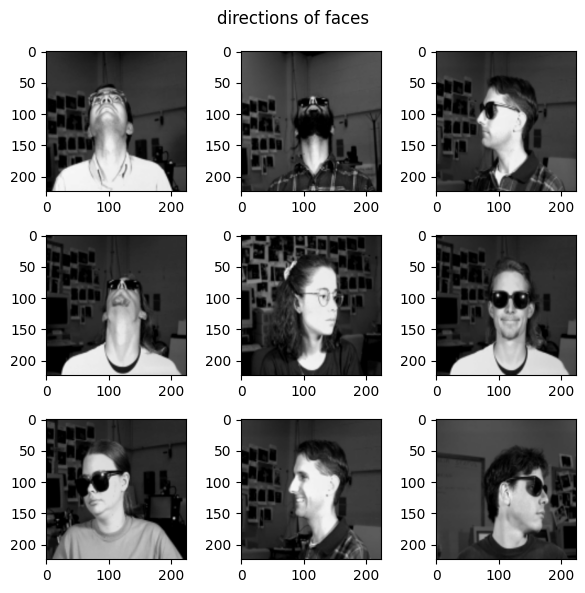

In [3]:
# Plots images in a grid
def plot_image_grid(images, grid=3, title=None):
    fig, axes = plt.subplots(grid,grid, figsize=(grid*2,grid*2))
    for i in range(grid):
        for j in range(grid):
            if i*grid + j < len(images):
                axes[i][j].imshow(images[i*grid + j].astype('uint8'))
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    
X = np.concatenate([x for x, y in train_dataset], axis=0)
plot_image_grid(X, title="directions of faces")

## Load Classification Model
Load a pre-trained model provided by Keras. Feel free to use any model, we tested this example with the `keras.applications.ResNet50()` model, and you can see how to use it here: https://keras.io/api/applications/resnet/#resnet50-function. 

In [4]:
resnet = keras.applications.ResNet50(weights="imagenet", include_top=False)
resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │       0 │ -                    │
│ (InputLayer)        │ None, 3)          │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_pad           │ (None, None,      │       0 │ input_layer[0][0]    │
│ (ZeroPadding2D)     │ None, 3)          │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │   9,472 │ conv1_pad[0][0]      │
│                     │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_bn            │ (None, None,      │     256 │ conv1_conv[0][0]     │
│ (BatchNormalizatio… │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_relu          │ (None, None,      │       0 │ conv1_bn[0][0]       │
│ (Activation)        │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ pool1_pad           │ (None, None,      │       0 │ conv1_relu[0][0]     │
│ (ZeroPadding2D)     │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ pool1_pool          │ (None, None,      │       0 │ pool1_pad[0][0]      │
│ (MaxPooling2D)      │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_1_conv │ (None, None,      │   4,160 │ pool1_pool[0][0]     │
│ (Conv2D)            │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │     256 │ conv2_block1_1_conv… │
│ (BatchNormalizatio… │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_1_relu │ (None, None,      │       0 │ conv2_block1_1_bn[0… │
│ (Activation)        │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_conv │ (None, None,      │  36,928 │ conv2_block1_1_relu… │
│ (Conv2D)            │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │     256 │ conv2_block1_2_conv… │
│ (BatchNormalizatio… │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_relu │ (None, None,      │       0 │ conv2_block1_2_bn[0… │
│ (Activation)        │ None, 64)         │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_0_conv │ (None, None,      │  16,640 │ pool1_pool[0][0]     │
│ (Conv2D)            │ None, 256)        │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_3_conv │ (None, None,      │  16,640 │ conv2_block1_2_relu… │
│ (Conv2D)            │ None, 256)        │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │   1,024 │ conv2_block1_0_conv… │
│ (BatchNormalizatio… │ None, 256)        │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │   1,024 │ conv2_block1_3_conv

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Build Transfer Learning Model
Freeze the layers in the pre-trained model by setting the model's or layer's `.trainable` to be `False`, and add a few trainable layers to the end of the model for our training process using the Sequential or Functional API. You can try adding one `Conv2D()` layer, one `Flatten()` layer, and one `Dense()` layer. Remember that the last `Dense()` layer needs to be updated to predict 4 classes.

In [5]:
resnet.trainable = False

In [6]:
inputs = keras.Input(shape=(224, 224, 3))
x = resnet(inputs, training=False)
x = keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)        │ 23,587,712 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 16)          │    294,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 400)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 4)                 │      1,604 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 23,884,244 (91.11 MB)

 Trainable params: 296,532 (1.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Train Classification Model
Define the optimizer and loss to use for the training process with `model.compile()`, and run the training loop on the dataset with `model.fit()`

In [7]:
model.compile(
    optimizer="adam",  # Optimizer
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=['accuracy'],
)

In [8]:
# Should be able to get at least 70% for validation accuracy
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=2, 
)

# NOTE: 1-5 epochs should be suitable for this task based on the learning rate of your optimizer.
# NOTE: training could take a while since we are using a large pre-trained model.

Epoch 1/2


2023-12-17 15:15:52.615462: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4855 - loss: 3.2869 - val_accuracy: 0.8952 - val_loss: 0.2994
Epoch 2/2
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 882ms/step - accuracy: 0.9519 - loss: 0.1082 - val_accuracy: 0.9516 - val_loss: 0.1063


In [9]:
history_df = pd.DataFrame(history.history)
history_df.head(3)

,accuracy,loss,val_accuracy,val_loss
0,0.680,1.813114,0.895161,0.299399
1,0.964,0.087673,0.951613,0.106338


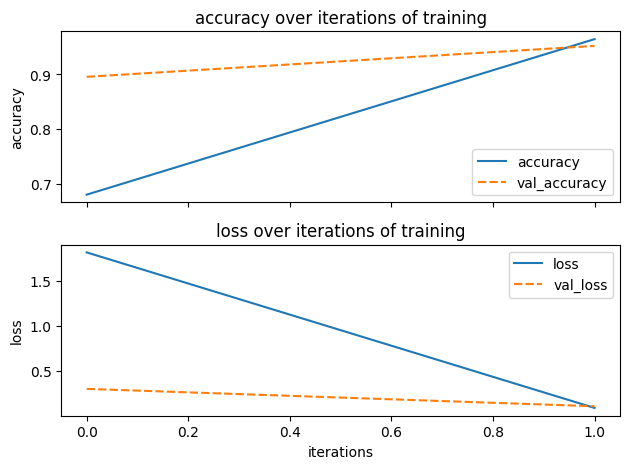

In [10]:
# Helper function to plot accuracy and loss of the run
def plot_history(history_df):
    fig, axes = plt.subplots(2,1, sharex=True)
    sns.lineplot(data=history_df[["accuracy", "val_accuracy"]], ax=axes[0]).set(
        title="accuracy over iterations of training",
        xlabel="iterations",
        ylabel="accuracy"
    )
    sns.lineplot(data=history_df[["loss", "val_loss"]], ax=axes[1]).set(
        title="loss over iterations of training",
        xlabel="iterations",
        ylabel="loss"
    )
    plt.tight_layout()
plot_history(history_df)

## Analyze the Model
Plotting a confusion matrix and visualizing incorrectly classified images

In [11]:
labels = sorted(["left", "right", "up", "straight"])

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  


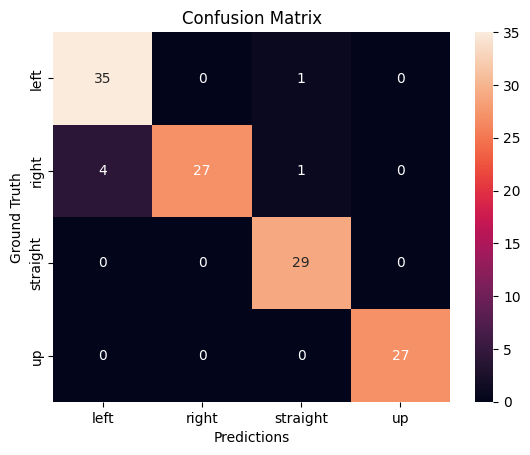

In [12]:
def confusion_matrix(y_true, y_pred):
    labels = np.unique(y_true)
    matrix = np.zeros((len(labels), len(labels)))
    for i, label_true in enumerate(labels):
        for j, label_pred in enumerate(labels):
            matrix[i][j] = np.count_nonzero((y_true == label_true) & (y_pred == label_pred))
    return matrix

def get_confusion_matrix(model, dataset):
    y_true = np.argmax(np.concatenate([y for x, y in dataset], axis=0), axis=1)
    y_pred = np.argmax(model.predict(dataset), axis=1)
    confusion_mat = confusion_matrix(y_true, y_pred)
    confusion_df = pd.DataFrame(confusion_mat, columns=labels, index=labels)
    sns.heatmap(confusion_df, annot=True).set(
        title="Confusion Matrix",
        xlabel="Predictions",
        ylabel="Ground Truth"
    )
get_confusion_matrix(model, validation_dataset)

In [13]:
y_true = np.argmax(np.concatenate([y for x, y in validation_dataset], axis=0), axis=1)
X = np.concatenate([x for x, y in validation_dataset], axis=0)
y_pred = np.argmax(model.predict(validation_dataset), axis=1)
predictions = list(zip(X, y_true, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step


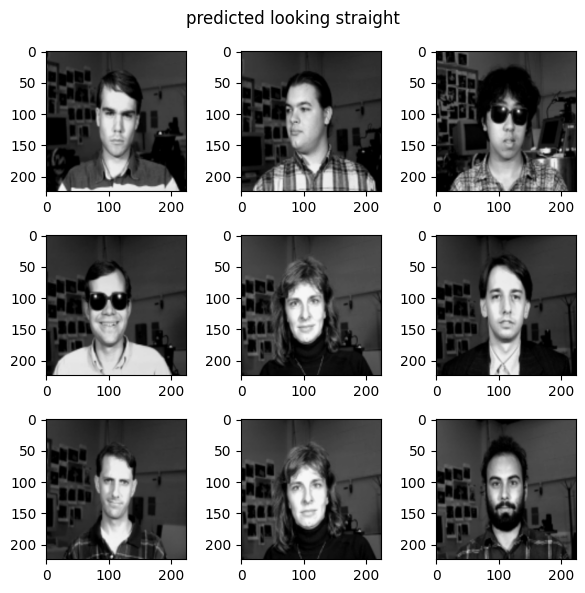

In [14]:
predictions1 = [image for image, y_true, y_pred in predictions if y_pred == 2]
plot_image_grid(predictions1, grid=3, title="predicted looking straight")

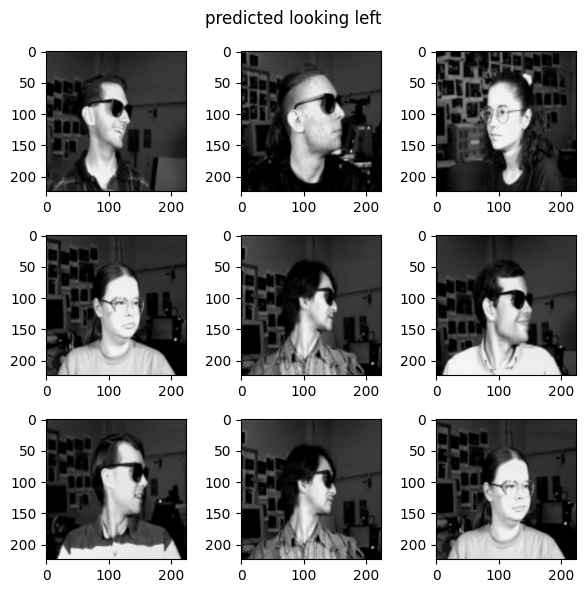

In [15]:
predictions1 = [image for image, y_true, y_pred in predictions if y_pred == 0]
plot_image_grid(predictions1, grid=3, title="predicted looking left")